In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Definition of TES algorithm

In [2]:
class HoltWinters:
    def __init__(self, alpha, beta, gamma,dampening, season_length,additive=False):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.dampening = dampening
        self.season_length = season_length
        self.additive = additive
    
    def fit_predict(self,Y, h):
        n = len(Y)
        L = np.zeros(n) # level array
        T = np.zeros(n) # trend array
        S = np.zeros(n) # seasonal array
        F = np.zeros(h) # forecast array

        # Initialize level, trend, and seasonal components
        L[0] = np.mean(Y[:self.season_length])
        T[0] = (np.mean(Y[self.season_length:2*self.season_length]) - L[0]) / self.season_length
        DES = False
        #if we have less than 52 weeks of data, fall back to Double exponential Smoothing
        if n < self.season_length:
            DES = True
            print("Warning: Not enough data points to compute seasonal components. Falling back to Double Exponential Smoothing.")
            self.gamma = 0.0
            S = np.ones(n)  # No seasonal component
        else:
            for i in range(self.season_length):
                S[i] = Y[i] / L[0]

        # Holt-Winters equations
        for t in range(self.season_length, n):
            if self.additive:
                L[t] = self.alpha * (Y[t] - S[t - self.season_length]) + (1 - self.alpha) * (L[t - 1] + self.dampening * T[t - 1])
                T[t] = self.beta * (L[t] - L[t - 1]) + (1 - self.beta) * self.dampening * T[t - 1]
                S[t] = self.gamma * (Y[t] - L[t]) + (1 - self.gamma) * S[t - self.season_length]
            else:    
                L[t] = self.alpha * (Y[t] / S[t - self.season_length]) + (1 - self.alpha) * (L[t - 1] + self.dampening * T[t - 1])
                T[t] = self.beta * (L[t] - L[t - 1]) + (1 - self.beta) * self.dampening * T[t - 1]
                S[t] = self.gamma * (Y[t] / L[t]) + (1 - self.gamma) * S[t - self.season_length]
            
        # Forecasting
        for t in range(h):
            if self.additive:
                F[t] = L[n - 1] + (t + 1) * T[-1] + S[n - self.season_length + t%self.season_length]
            else:
                F[t] = (L[n - 1] + (t + 1) * T[-1]) * S[n - self.season_length + t%self.season_length]  
        return F  

# Loading and splitting data

In [3]:
sales_data = pd.read_csv("data/train.csv")
sales_data

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [4]:
print("The stores in the datasets are:\n", sales_data['Store'].sort_values().unique())
print("\nThe departments in the datasets are:\n", sales_data['Dept'].sort_values().unique())

The stores in the datasets are:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]

The departments in the datasets are:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 58 59 60 65 67 71 72 74 77 78 79 80 81 82 83 85 87 90
 91 92 93 94 95 96 97 98 99]


In [5]:
# lets look at the amount of data for each store-department combination

counts_df = sales_data.groupby(['Store','Dept']).size().reset_index(name='Count')
counts_df

,Store,Dept,Count
0,1,1,143
1,1,2,143
2,1,3,143
3,1,4,143
4,1,5,143
...,...,...,...
3326,45,94,134
3327,45,95,143
3328,45,96,2
3329,45,97,143


For most of the combinations we have a complete dataset, however there are some exceptions for each store. Lets check the statistics for each store and compare

In [6]:
# statistics for each Store
counts_df.groupby('Store')['Count'].agg(['min','max','mean','median','std'])

,min,max,mean,median,std
Store,,,,,
1,3,143,133.038961,143.0,31.665788
2,2,143,131.256410,143.0,35.319483
3,1,143,125.500000,143.0,41.834011
4,1,143,131.692308,143.0,35.606547
5,1,143,124.986111,143.0,40.880621
6,2,143,132.610390,143.0,33.121052
7,1,143,128.447368,143.0,35.823045
8,3,143,130.197368,143.0,38.261563
9,2,143,121.465753,143.0,45.555547


We can see that some of the series have a very limited amount of data. In order to perform TES we would need to have at least 52 weeks of data for the initialization and 4 weeks for forecasting. Lets see which store has the least amount of departments we can drop.

In [7]:
counts_df[counts_df['Count'] >= 56].groupby('Store')['Count'].count().sort_values(ascending=False).head(5)

Store
13    74
10    73
34    73
2     72
6     72
Name: Count, dtype: int64

We'll use data only for store 13 moving forward. We'll also drop the departments with less than 56 data points.

In [8]:
departments_to_use = counts_df[(counts_df['Count'] >= 56) & (counts_df['Store'] == 13)]['Dept'].unique()

In [9]:
sales_data_filtered = sales_data[(sales_data['Store'] == 13) & (sales_data['Dept'].isin(departments_to_use))].sort_values(by=['Store', 'Dept', 'Date'])

sales_series = {}
groups =sales_data_filtered.groupby(['Store', 'Dept'])

for name, group in groups:
    sales_series[str(name[0]) + "-" + str(name[1])] = group[['Weekly_Sales','Date']].rename(columns={'Weekly_Sales': 'sales'}).set_index('Date')
    

print(f"Number of time series: {len(sales_series)}")

Number of time series: 74


## Data augmentation

During testing, we found 2 departments (13-45 and 13-51) that have outlier values.

### 13-45

,sales
Date,
2010-02-05,35.32
2010-02-12,23.38
2010-02-19,25.41
2010-02-26,21.91
2010-03-05,27.85
...,...
2012-09-14,53.73
2012-09-21,29.88
2012-09-28,17.91


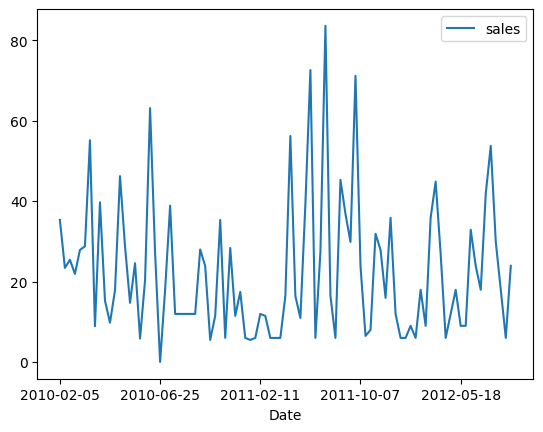

In [10]:
key = '13-45'
series = sales_series[key]
series.plot()
series

There is a single 0 value that probably ruins the calculation of the data. Looking at the data, the date (2010-06-25) is not a holiday so it must be an outlier within the data itself. We can also notice that, ignoring this value, the soft lower bound of the data is somewhere around 5.5. We will change this value to 5 to preserve the model's numerical calculations.

In [11]:
series[series.index == '2010-06-25'] = 5
sales_series[key] = series

### 13-51

,sales
Date,
2010-02-05,31.58
2010-02-12,25.04
2010-02-19,14.00
2010-02-26,55.52
2010-03-05,23.38
2010-03-12,18.00
2010-03-19,71.00
2010-03-26,65.32
2010-04-02,14.16


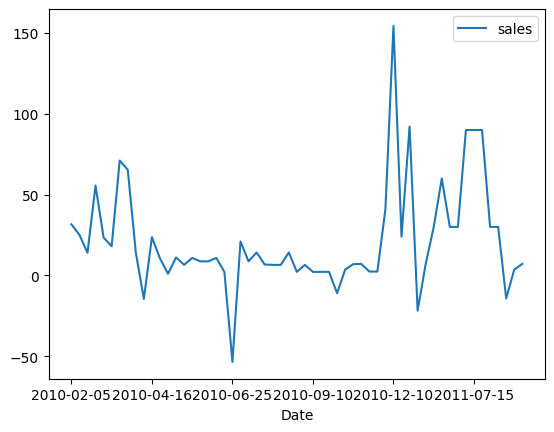

In [15]:
key = '13-51'
series = sales_series[key]
series.plot()
series

The data contains negative values which should be impossible for sales data. We can shift everything to above 0 and see if that helps out the model.

In [16]:
series = series + (0.01 - series.min())  # 0.01 to avoid zero devision
sales_series[key] = series

## Sanity check if everything so far works.

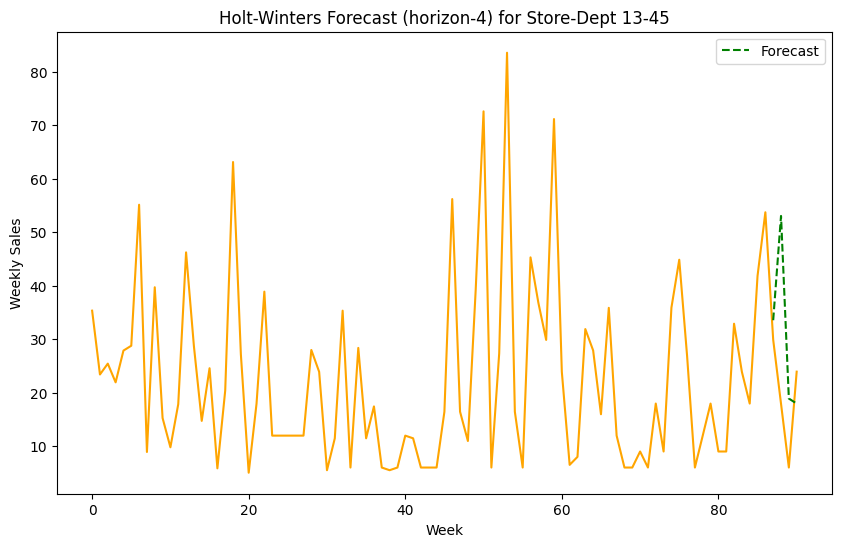

In [23]:
key = '13-45'
series = sales_series[key]['sales']
tes = HoltWinters(
    alpha=0.2,
    beta=0.1,
    gamma=0.1,
    dampening=1.0,
    season_length=52,
    additive=False
)
fcs = tes.fit_predict(series.values[:-4], h=4)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)), series.values, color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast (horizon-4) for Store-Dept {key}')
plt.legend()
plt.show()

# Method 1: Per item forecasting

## Forecasting and parameters optimization

In [24]:
def forecast(series, h, alpha, beta, gamma,additive=False):
    model = HoltWinters(
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        dampening=1.0,
        season_length=52,
        additive=additive
    )
    """Forecasts the given time series with horizon-1 for the last h points of the data using the Holt-Winters method."""
    fcs = np.zeros(h)
    for horizon in range(1,h+1):
        fcs[horizon-1] = model.fit_predict(series['sales'].values[:-(h+1-horizon)], h=1)[0]
    return fcs

### Horizon-1 forecasts example

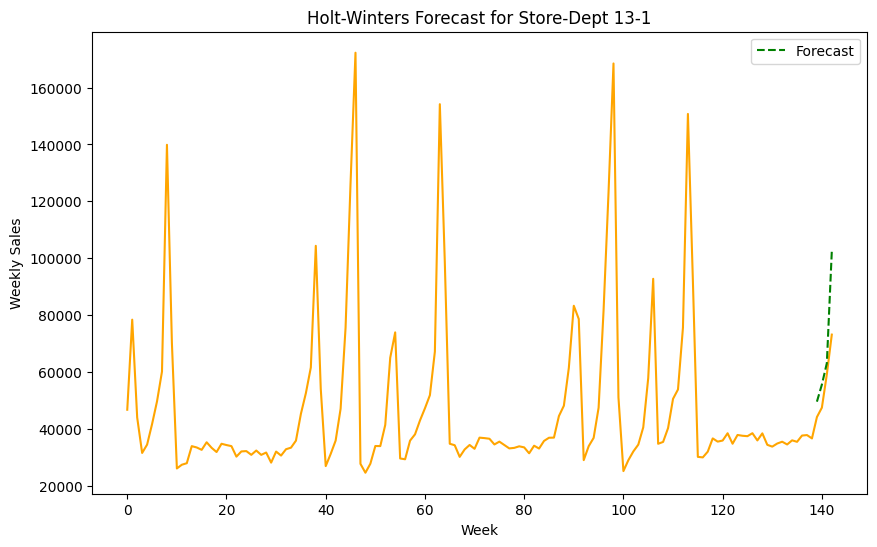

In [25]:
key = '13-1'
series = sales_series[key]
h = 4
fcs = forecast(series, h, alpha=0.2, beta=0.1, gamma=0.1)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)), series['sales'], color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

### Grid search example

In [72]:

def grid_search(series, h, alpha_values, beta_values, gamma_values,additive=False,tqdm_disable=False):
    
    best_params = (None, None, None)
    best_mse = float('inf')
    best_mae = float('inf')
    best_mape = float('inf')
    
    for alpha in tqdm(alpha_values,disable=tqdm_disable):
        for beta in beta_values:
            for gamma in gamma_values:
                fcs = forecast(series, h, alpha, beta, gamma, additive=additive)
                actuals = series['sales'].values[-h:]
                mape = np.mean(np.abs((actuals - fcs) / actuals)) * 100
                print(actuals,fcs)
                mse = np.mean((actuals - fcs) ** 2)
                mae = np.mean(np.abs(actuals - fcs))
                if mape < best_mape:
                    best_mape = mape
                    best_mse = mse
                    best_mae = mae
                    best_params = (alpha, beta, gamma)
                    
    return best_params, best_mse,best_mae, best_mape

#### Multiplicative

100%|██████████| 19/19 [00:06<00:00,  2.74it/s]

Best Parameters: alpha=0.15000000000000002, beta=0.15000000000000002, gamma=0.9500000000000001
Best MSE: 4967204.524638796 | Best MAE: 1866.6587821333706 | Best MAPE: 3.72%


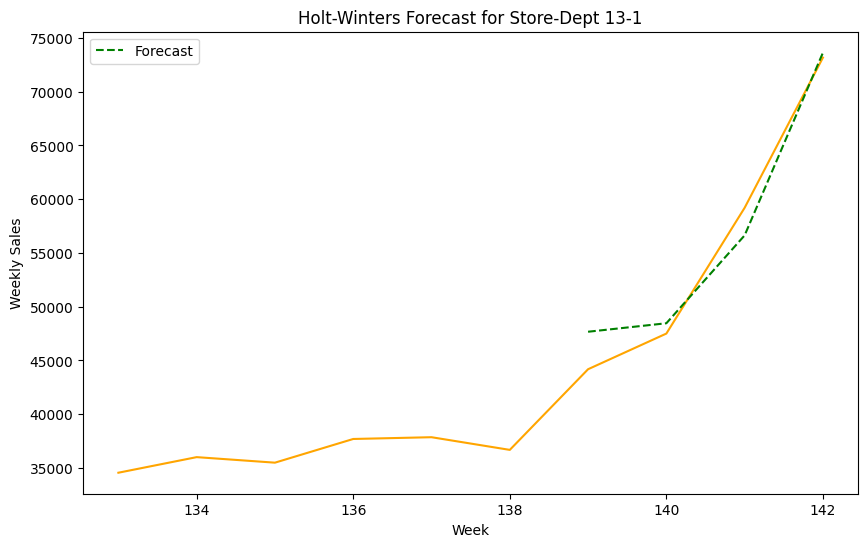

In [27]:
key = '13-1'
series = sales_series[key]
h = 4
additive=False
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params, mse, mae, mape = grid_search(series,h, alpha, beta, gamma, additive=additive)
print(f"Best Parameters: alpha={params[0]}, beta={params[1]}, gamma={params[2]}")
print(f"Best MSE: {mse} | Best MAE: {mae} | Best MAPE: {mape:0.2f}%")
fcs = forecast(series, h, params[0], params[1], params[2], additive=additive)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)-10,len(series)), series['sales'].values[-10:], color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

#### Additive

100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

Best Parameters: alpha=0.2, beta=0.35000000000000003, gamma=0.9500000000000001
Best MSE: 988127.3594880891 | Best MAE: 863.8879267229186 | Best MAPE: 1.62%


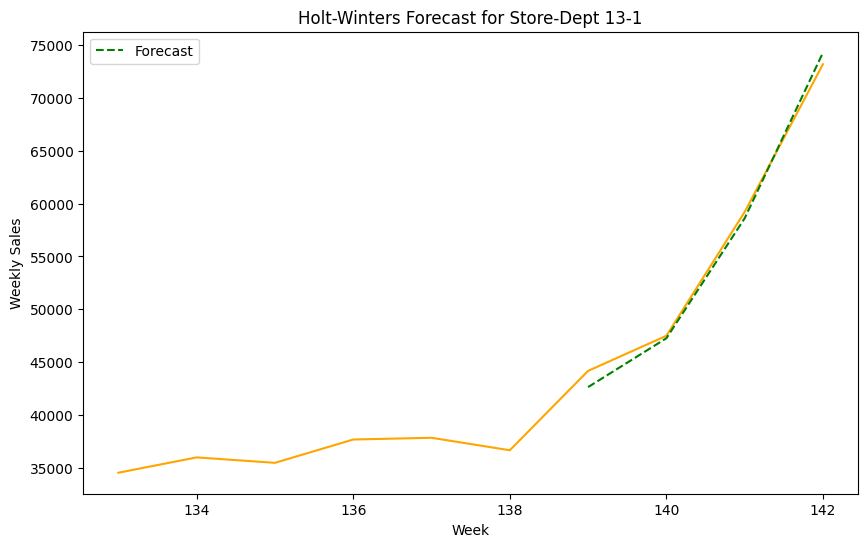

In [28]:
key = '13-1'
series = sales_series[key]
h = 4
additive=True
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params, mse, mae, mape = grid_search(series,h, alpha, beta, gamma, additive=additive)
print(f"Best Parameters: alpha={params[0]}, beta={params[1]}, gamma={params[2]}")
print(f"Best MSE: {mse} | Best MAE: {mae} | Best MAPE: {mape:0.2f}%")
fcs = forecast(series, h, params[0], params[1], params[2], additive=additive)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)-10,len(series)), series['sales'].values[-10:], color='orange')
plt.plot(range(len(series)-4,len(series)), fcs, label='Forecast', color='green', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

In this case (store 13, department 1) we can see that additive TES performs better, however there are some cases where the opposite might be true.

In [29]:
key = '13-23'
series = sales_series[key]
h = 4
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params_additive, mse_additive, mae_additive, mape_additive = grid_search(series,h, alpha, beta, gamma, additive=True)
print(f"Best Parameters for additive: alpha={params_additive[0]:0.2f}, beta={params_additive[1]:0.2f}, gamma={params_additive[2]:0.2f}")
print(f"Best MSE: {mse_additive} | Best MAE: {mae_additive} | Best MAPE: {mape_additive:0.2f}%")
params_mult, mse_mult, mae_mult, mape_mult = grid_search(series,h, alpha, beta, gamma, additive=False)
print(f"Best Parameters for multiplicative: alpha={params_mult[0]:0.2f}, beta={params_mult[1]:0.2f}, gamma={params_mult[2]:0.2f}")
print(f"Best MSE: {mse_mult} | Best MAE: {mae_mult} | Best MAPE: {mape_mult:0.2f}%")

100%|██████████| 19/19 [00:06<00:00,  2.75it/s]


Best Parameters for additive: alpha=0.05, beta=0.15, gamma=0.95
Best MSE: 9540233.917124942 | Best MAE: 2330.055185842174 | Best MAPE: 6.85%


100%|██████████| 19/19 [00:07<00:00,  2.66it/s]

Best Parameters for multiplicative: alpha=0.10, beta=0.55, gamma=0.25
Best MSE: 400465.1677509444 | Best MAE: 503.7455493684902 | Best MAPE: 1.48%


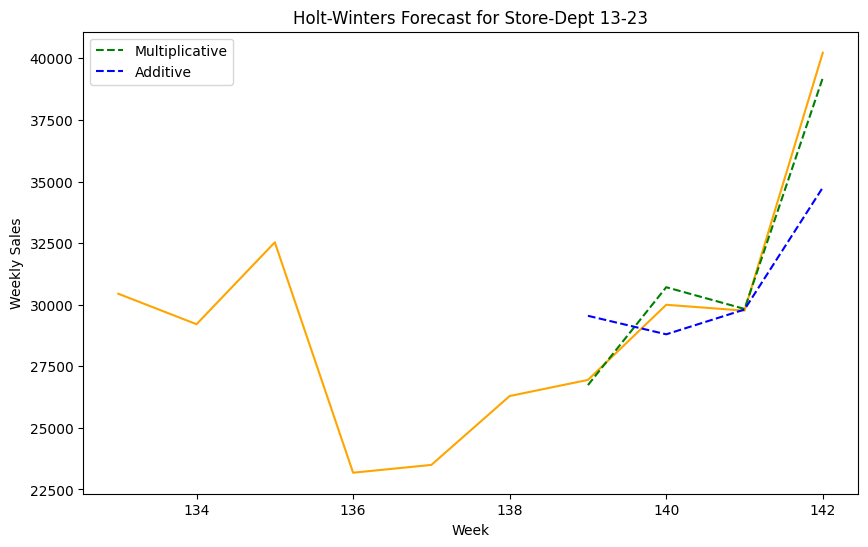

In [30]:
fcs_mult= forecast(series, h, params_mult[0], params_mult[1], params_mult[2], additive=False)
fcs_add= forecast(series, h, params_additive[0], params_additive[1], params_additive[2], additive=True)
plt.figure(figsize=(10, 6))
plt.plot(range(len(series)-10,len(series)), series['sales'].values[-10:], color='orange')
plt.plot(range(len(series)-4,len(series)), fcs_mult, label='Multiplicative', color='green', linestyle='--')
plt.plot(range(len(series)-4,len(series)), fcs_add, label='Additive', color='blue', linestyle='--')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title(f'Holt-Winters Forecast for Store-Dept {key}')
plt.legend()
plt.show()

## Finding best parameter per store-department combination

In [ ]:
alphas = dict()
betas = dict()
gammas = dict()
mses = dict()
maes = dict()
mapes = dict()
additives = dict()
# for key in tqdm(['13-1','13-23','13-33','13-35','13-13']):
for key in tqdm(sales_series.keys()):
    series = sales_series[key]
    h = 4
    alpha = np.arange(0.05, 1.0, 0.05)
    beta = np.arange(0.05, 1.0, 0.05)
    gamma = np.arange(0.05, 1.0, 0.05)
    params_mult, mse_mult, mae_mult, mape_mult = grid_search(series,h, alpha, beta, gamma, additive=False,tqdm_disable=True)
    params_add, mse_add, mae_add, mape_add = grid_search(series,h, alpha, beta, gamma, additive=True,tqdm_disable=True)
    if mape_mult < mape_add:
        alphas[key] = params_mult[0]
        betas[key] = params_mult[1]
        gammas[key] = params_mult[2]
        mses[key] = mse_mult
        maes[key] = mae_mult
        mapes[key] = mape_mult
        additives[key] = False
    else:
        alphas[key] = params_add[0]
        betas[key] = params_add[1]
        gammas[key] = params_add[2]
        mses[key] = mse_add
        maes[key] = mae_add
        mapes[key] = mape_add
        additives[key] = True
        
best_params_df = pd.DataFrame({
    'dept': {key: key.split('-')[1] for key in sales_series.keys()},
    'alpha': alphas,
    'beta': betas,
    'gamma': gammas,
    'mse': mses,
    'mae': maes,
    'mape': mapes,
    'additive': additives
    })
#save for later use
best_params_df.reset_index().drop(columns=['index']).to_csv("holt_winters_best_params.csv",index=False)

 55%|█████▌    | 41/74 [10:39<08:41, 15.80s/it]/tmp/ipykernel_27827/2572698837.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  L[t] = self.alpha * (Y[t] / S[t - self.season_length]) + (1 - self.alpha) * (L[t - 1] + self.dampening * T[t - 1])
/tmp/ipykernel_27827/2572698837.py:39: RuntimeWarning: invalid value encountered in scalar subtract
  T[t] = self.beta * (L[t] - L[t - 1]) + (1 - self.beta) * self.dampening * T[t - 1]
100%|██████████| 74/74 [18:43<00:00, 15.19s/it]


In [31]:
best_params_df = pd.read_csv("holt_winters_best_params.csv")

In [38]:
best_params_df

,dept,alpha,beta,gamma,mse,mae,mape,additive
0,1,0.20,0.35,0.95,9.881274e+05,863.887927,1.616240,True
1,2,0.30,0.40,0.70,2.311681e+05,345.002394,0.469651,True
2,3,0.85,0.05,0.90,1.668811e+06,795.952705,4.430767,True
3,4,0.45,0.25,0.85,4.204587e+05,479.486300,1.116615,True
4,5,0.15,0.10,0.40,3.000008e+05,411.358703,0.850608,True
...,...,...,...,...,...,...,...,...
70,95,0.20,0.25,0.55,6.135097e+05,592.788821,0.429447,False
71,96,0.10,0.35,0.20,3.676005e+05,402.562160,4.095860,True
72,97,0.20,0.60,0.40,2.425386e+04,111.842996,0.378823,False
73,98,0.20,0.15,0.85,1.969253e+05,320.456108,2.015598,False


In [44]:
fcs = dict()
for key in tqdm(sales_series.keys()):
    dept = int(key.split('-')[1])
    series = sales_series[key]
    h = 4
    
    fcs[key] = forecast(series, h, best_params_df.loc[best_params_df['dept']==dept, 'alpha'].values[0],
                        best_params_df.loc[best_params_df['dept']==dept, 'beta'].values[0],
                        best_params_df.loc[best_params_df['dept']==dept, 'gamma'].values[0],
                        additive=best_params_df.loc[best_params_df['dept']==dept, 'additive'].values[0]
                        )

 35%|███▌      | 26/74 [00:00<00:00, 254.47it/s]

100%|██████████| 74/74 [00:00<00:00, 181.46it/s]


# Method 2: Aggregated data forecasting

## Aggregating by store

We will add all departments within one store and forecast on the aggregated data. This will yield a single prediction for the sales of the whole store, which we would need to de-aggregated afterwards to get predictions for each department within. In order to do this we will keep weights for each department's contribution.

In [ ]:
departments_weights = {
    d : sales_series[f'13-{d}']['sales'].sum()
    for d in departments_to_use
    }
departments_weights = pd.DataFrame.from_dict(departments_weights, orient='index', columns=['sales'])
# agg_series = sales_data_filtered.groupby('Date')['Weekly_Sales'].sum()
departments_weights['sales'] = departments_weights['sales'] / departments_weights['sales'].sum()
departments_weights

,sales
1,0.023470
2,0.038105
3,0.013036
4,0.021246
5,0.028345
...,...
94,0.037697
95,0.068306
96,0.004575
97,0.013755


In [ ]:
# aggregating the series into a single series for the store
agg_data = sum(sales_series.values())
h = 4
alpha = np.arange(0.05, 1.0, 0.05)
beta = np.arange(0.05, 1.0, 0.05)
gamma = np.arange(0.05, 1.0, 0.05)
params_additive, mse_additive, mae_additive, mape_additive = grid_search(agg_data,h, alpha, beta, gamma, additive=True)
params_mult, mse_mult, mae_mult, mape_mult = grid_search(agg_data,h, alpha, beta, gamma, additive=False)

In [77]:
sales_series['13-1'] + sales_series['13-45']

,sales
Date,
2010-02-05,46797.22
2010-02-12,78439.32
2010-02-19,44067.60
2010-02-26,31595.95
2010-03-05,34532.92
...,...
2012-09-28,36696.57
2012-10-05,NaN
2012-10-12,47502.93


In [74]:
forecast(agg_data,h,0.2,0.1,0.1,True)

array([nan, nan, nan, nan])

In [68]:
# print(f"Best Parameters for additive: alpha={params_additive[0]:0.2f}, beta={params_additive[1]:0.2f}, gamma={params_additive[2]:0.2f}")
print(f"Best MSE: {mse_additive} | Best MAE: {mae_additive} | Best MAPE: {mape_additive:0.2f}%")
print(f"Best Parameters for multiplicative: alpha={params_mult[0]:0.2f}, beta={params_mult[1]:0.2f}, gamma={params_mult[2]:0.2f}")
print(f"Best MSE: {mse_mult} | Best MAE: {mae_mult} | Best MAPE: {mape_mult:0.2f}%")

Best MSE: inf | Best MAE: inf | Best MAPE: inf%


TypeError: unsupported format string passed to NoneType.__format__